# Import packages

In [1]:
import xgi
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import math

# Hyperedge adding function

In [189]:
def add_hyperedge(H, labels, p, q, num_ext, num_new):
    e_prime = [] # create an empty new edge called e_prime

    ## randomly select an existing hyperedge e to start with
    e_num = random.randint(0, H.num_edges - 1)
    e = H.edges.members()[e_num]
    e_size = H.edges.size.asdict().get(e_num)

    ## randomly select a node u from e
    u_num = random.randint(0, e_size - 1)
    u = list(e)[u_num]
    u_label = H.nodes.attrs.asdict().get(u).get("label")
    e_prime.append(u)

    ## add other nodes from e to e_prime
    # add node with same label as u with prob p
    # add node with different label from u with prob q
    for node in e:
        if H.nodes.attrs.asdict().get(node).get("label") == u_label:
            prob = p
        else:
            prob = q
        if random.random() < prob:
            e_prime.append(node)
    
    ## add exterior nodes
    for i in range(0, num_ext):
        if len(list(H.nodes - e)) > 0:
            exterior_node = random.sample(list(H.nodes - e), 1)[0] # randomly sample a node from outside the existing hyperedge
            e_prime.append(exterior_node)
        # else:
        #     print("No remaining exterior nodes, one failed to add")

    ## add new nodes
    for i in range(0, num_new):
        new_node = len(H.nodes)
        H.add_node(new_node)
        new_label = np.random.choice([labels[0], labels[1]])
        H.set_node_attributes({new_node : new_label}, name = "label")
        e_prime.append(new_node)
    
    
    H.add_edge(e_prime)
    
    # print("e_prime is: " + str(H.num_edges - 1) +  "   edge is: " + str(e_num) + "  u is: " + str(u))

# Functions to compute the marginal likelihood

In [267]:
## Calculates the likelihood of p and q
## given the fact that node n in e is added or not added to e_prime
def bern_lik(H, node, u, e_prime, p, q):
    global isin
    global notin
    u_label = H.nodes.attrs.asdict().get(u).get("label") # Get the label of u
    node_label = H.nodes.attrs.asdict().get(node).get("label") # Get the label of node
    if node == u: # if the node is u, just set lik to 1
        lik = 1
    elif node_label == u_label: # if the node is not u but has the same label
        if node in H.edges.members(e_prime): # and if the node is in e_prime
            lik = p # then p and q have their values with probability p
            isin += 1
        else: # and if the node is not in e_prime
            lik = 1 - p  # then p and q have their values with probability (1 - p)
            notin += 1
    else: # if the node does not have the same label as u
        if node in H.edges.members(e_prime): # and if the node is in e_prime
            lik = q # then p and q have their values with probability q
            isin += 1
        else: # and if the node is not in e_prime
            lik = 1 - q # then p and q have their values with probability (1 - q)
            notin += 1
    return lik

In [266]:
## Calculates the likelihood of p and q
## Given the fact that edge e_prime was added to the hypergraph
## Using existing edge e and node u within e
def lik_given_e_u_eprime(H, e, u, e_prime, p, q):
    lik = 1 # set lik to 1 (multiplicative identity)
    edge_set = list(H.edges)[0:e_prime] # possible values of e are all edges created before e_prime
    vertex_set = list(H.nodes)[0:e_prime + 1] # possible nodes in e_prime are all nodes created before e_prime
    for node in H.edges.members(e): # for each node in e
        lik *= bern_lik(H, node, u, e_prime, p, q) # calculate the likelihood of of p and q
        # given the fact that node n in e is added or not added to e_prime.
    lik = lik * (1 / len(edge_set)) * 0.5 # multiply by the probability of picking e to be the existing edge
    # and the probability of picking the chosen label for the new vertex
    if len(vertex_set) > len(H.edges.members(e)): # if there are nodes in the hypergraph outside e
        lik *= 1 / (len(vertex_set) - len(H.edges.members(e))) # multiply by the probability of picking the chosen ext node
    return lik

In [265]:
## Calculates the likelihood of p and q
## Given the fact that edge e_prime was added to the hypergraph
## Using existing edge e
def lik_given_e_eprime(H, e, e_prime, p, q):
    prob = 0 # set prob equal to 0 (additive identity) 
    for u in H.edges.members(e) and H.edges.members(e_prime): # for each node in both e and u
        prob += lik_given_e_u_eprime(H, e, u, e_prime, p, q) # compute likelihood of p and q
        # given the fact that edge e_prime was added to the hypergraph using existing edge e and node u within e
    return prob

In [278]:
## Calculates the likelihood of p and q
## Given the fact that edge e_prime was added to the hypergraph
def lik_given_eprime(H, eprime, p, q):
    prob = 0 # set prob equal to 0 (additive identity)
    for e in list(H.edges)[0:eprime]: # for each possible edge e
        print(lik_given_e_eprime(H, e, eprime, p, q))
        prob += lik_given_e_eprime(H, e, eprime, p, q) # compute the likelihood of p and q
        # given the fact that edge e_prime was added to the hypergraph
    return prob

In [279]:
## Computes the likelihood of p and q
## Given the fact that edges eprime_seq were added to the hypergraph
def lik_given_H(H, p, q):
    eprime_seq = list(H.edges)[1:] # let eprime_seq be all edges in H except the initial one
    prob = 1 # set prob equal to 1 (multiplicative identity)
    for eprime in eprime_seq: # for each new edge eprime in the hypergraph H
        lik = lik_given_eprime(H, eprime, p, q) # compute the likelihood of p and q
        # given the fact that eprime was added to the hypergraph
        prob = prob * lik # multiply the overall prob by that likelihood
    return prob

# Plot marginal likelihoods

In [224]:
p = 0.7 # set values of p and q
q = 0.4
H = xgi.Hypergraph([[0,1]]) # create hypergraph
H.set_node_attributes({0 : 0, 1 : 1}, name = "label") # set node labels
for i in range(0, 100): # add edges with node probabilities p and q
    add_hyperedge(H, [0,1], p, q, 1, 1)

In [228]:
isin = 0
notin = 0
p_q_lik3 = []
# for each combination of p and q, compute likelihood given edge sequence in H
for p in np.arange(0.1, 1.1, 0.1):
    for q in np.arange(0.1, 1.1, 0.1):
        lik = lik_given_H(H, p, q)
        p_q_lik3.append([p, q, lik])

In [229]:
# compute log of each likelihood value
# (unless the likelihood is 0)
df3 = np.array(p_q_lik3)
for i in range(len(df3[:,2])):
    if df3[i,2] > 0:
        df3[i,2] = math.log(df3[i,2])
    else:
        df3[i,2] = np.nan

<function matplotlib.pyplot.show(close=None, block=None)>

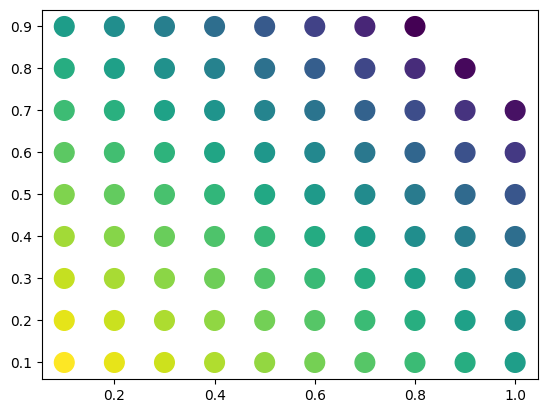

In [230]:
# plot results
plt.scatter(x = df3[:,0], y = df3[:,1], c = df3[:,2], s = 200)
plt.show

# Notes

- the ratio of nodes from e added to e_prime to nodes from e not added to e_prime is lower than anticipated
-  as we iterate through the edges in the edge sequence, the likelihood decreases
    - this is at least partially because the size of the edge set and the vertex set (which we divide by) are larger when we're calculating likelihoods for later edges

In [234]:
isin/notin

0.14658291948751942

In [275]:
print(lik_given_eprime(H, 5, 0.7, 0.4))
print(lik_given_eprime(H, 20, 0.7, 0.4))
print(lik_given_eprime(H, 70, 0.7, 0.4))

0.166644
0.015461016517027868
0.0017552362782238967
